<center> <h1> MNIST Classification with only 100 samples ! </h1> </center>
<center><i>By Andréa Joly</i></center>

## Target
The goal of this lab is to realize a Deep Learning algorithm for image classification of the MNIST dataset, with the constraint of using only 100 labeled images.
To evaluate the performance of our model, we will mainly observe the accuracy of our model on the test set predefined in MNIST.

## Introduction
In order to make this notebook comprehensible, only relevant and accuracy-enhancing solutions will be retained. In fact, this notebook does not retrace all the tests carried out. However, the following is a non-exhaustive list of methods tested and rejected:

* Dataset 
  - Training with 100 randomly labeled pictures
  - Training with 10 items per class, evenly distributed

* Learning model architecture: 
  - Semi Supervised
  - Auto Encoder
  - K-NN
  - CNN without regularization

## 0. Installation & Setup
* Modules Imports
* Device configuration

In [8]:
from collections import Counter

from torch import device, cuda, no_grad, optim, max
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset, Subset, DataLoader, Dataset

import matplotlib.pyplot as plt

import torch.nn as nn

import torch

In [10]:
# Device configuration
device = torch.device('cuda' if cuda.is_available() else 'cpu')
device

device(type='cpu')

## 1. Data Acquisition and Preprocessing
* Dataset download
* Keep and select only 100 images labeled
* Data Augmentation
* Create loaders

In [11]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [12]:
class RemoveLabel(Dataset):
    """ Remove Label from a Dataset """
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        # Delete label
        image, _ = self.dataset[index]
        return image
    
    def __len__(self):
        # Method required to use shuffle = True in DataLoader
        return len(self.dataset)

After training several models empirically. We realized that some classes were easier to classify than others. So we chose to use a non-equitable distribution of our different classes.

In [15]:
desired_images_per_class = {0: 8, 1: 5, 2: 10, 3: 10, 4: 10, 5: 12, 6: 9, 7: 11, 8: 14, 9: 11}

class_counts = {i: 0 for i in range(10)}

selected_indices = []

for i, (data, target) in enumerate(train_data):
    if class_counts[target] < desired_images_per_class[target]:
        selected_indices.append(i)
        class_counts[target] += 1

    if all(count == desired_images_per_class[label] for label, count in class_counts.items()):
        break

unselected_indices = [i for i in range(len(train_data)) if i not in selected_indices]

label_train_data = Subset(train_data, selected_indices)
unlabel_train_data = RemoveLabel(Subset(train_data, unselected_indices))

In [17]:
# Verify class repartition
class_counts = Counter([label for _, label in label_train_data])
class_counts

Counter({8: 14, 5: 12, 9: 11, 7: 11, 4: 10, 2: 10, 3: 10, 6: 9, 0: 8, 1: 5})

At this step, our dataset is divided as follows : 

<center>

| Dataset | Labeled | Unlabeled | Test        |
| :--------------|:----------:|:----------:|:-----------:|
| Size         |   100      |  59900     | 10000       |
| Dimensions     | [1, 28, 28]| [28, 28]   | [1, 28, 28] |

</center>

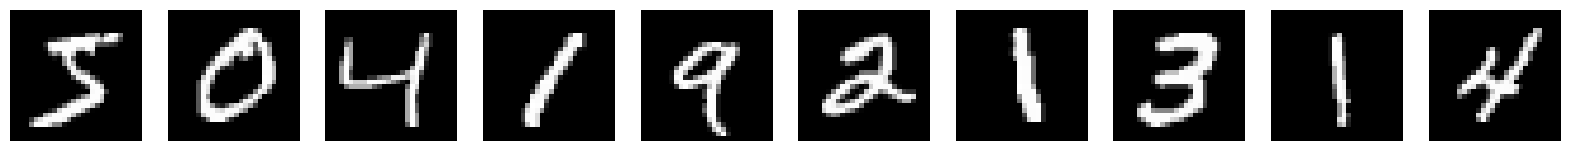

In [18]:
# Display original dataset
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(label_train_data[i][0].numpy().squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

Now, we augment the dataset: we generate new images from the original images with classic transformations (padding, Gaussian filter, etc)

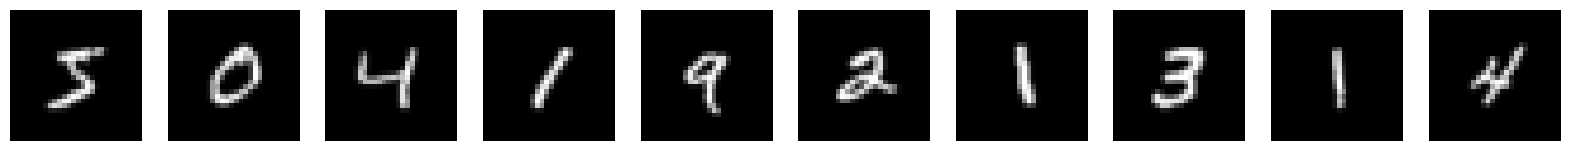

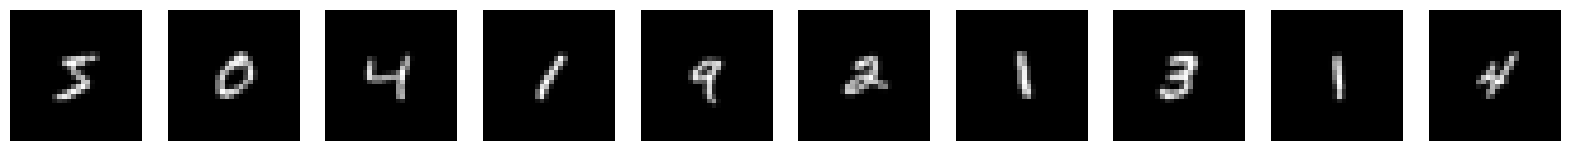

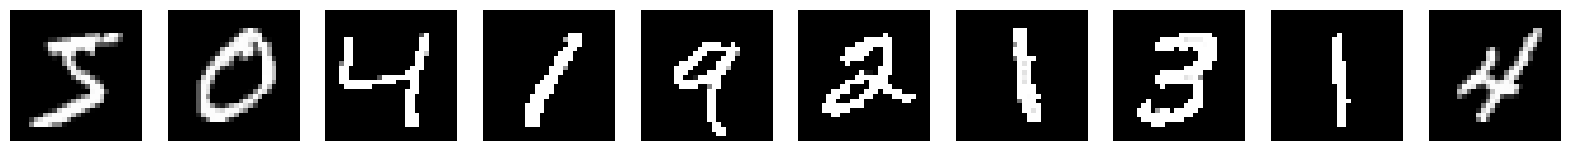

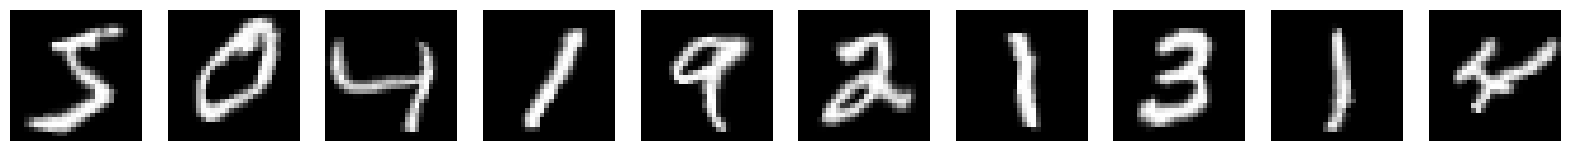

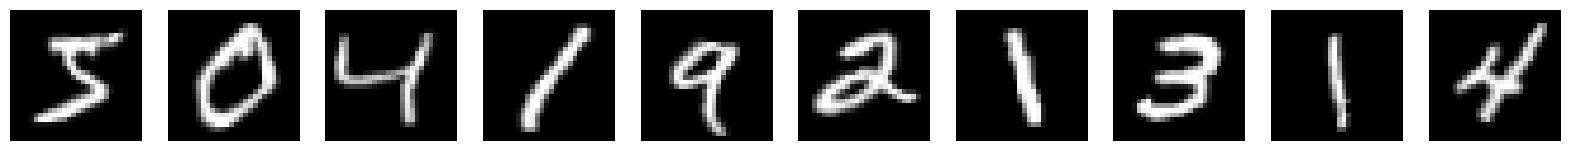

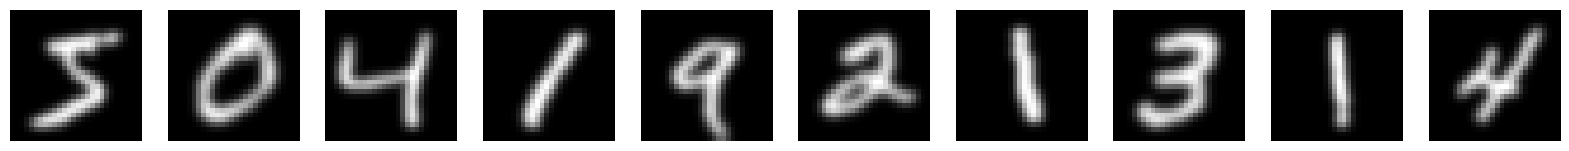

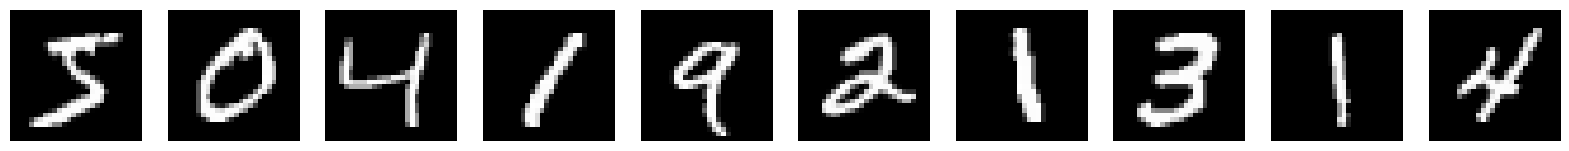

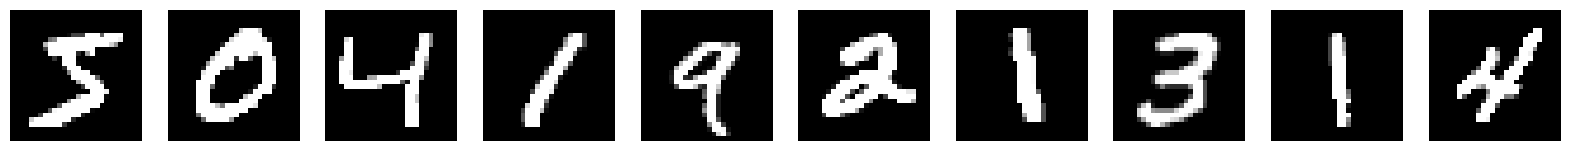

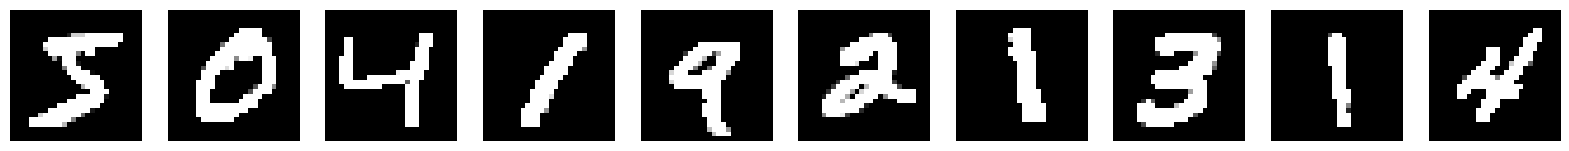

In [19]:
transformations = [
    transforms.Pad(8),
    transforms.Pad(16),
    transforms.RandomAdjustSharpness(50),
    transforms.ElasticTransform(alpha=60.0),
    transforms.ElasticTransform(alpha=30.0),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3)),
    transforms.ColorJitter(brightness=(1.0, 5.0)),
    transforms.ColorJitter(brightness=(10.0, 20.0))
]

for tranform in transformations:
    data_transforms = transforms.Compose([
            tranform,
            transforms.Resize((28, 28))
            ])
    transformed_dataset = [(data_transforms(data), target) for data, target in label_train_data]
    label_train_data = ConcatDataset([label_train_data,  Subset(transformed_dataset, range(100))])
    # Display new dataset
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        ax[i].imshow(transformed_dataset[i][0].numpy().squeeze(), cmap='gray')
        ax[i].axis('off')
    plt.show()

At this step, our dataset is divided as follows : 

<center>

| Dataset | Labeled | Unlabeled | Test        |
| :--------------|:----------:|:----------:|:-----------:|
| Size         |   1000      |  59900     | 10000       |
| Dimensions     | [1, 28, 28]| [28, 28]   | [1, 28, 28] |

</center>

### Loaders creation

In [ ]:
loaders = {
    'label_train' : DataLoader(label_train_data, batch_size=100, num_workers=4, shuffle=True),
    'test'  : DataLoader(test_data, batch_size=100, num_workers=4)
}

## 2. Model
* CNN Architecture
* Model training
* Data Augmentation


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        self.dropout = nn.Dropout(0.5) # to avoid overfitting

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        output = self.out(x)
        return  output, x


For each epoch, we generate new random images from label_train_data to increase the accuracy of our model. 
Random images are very useful for reducing overfitting problems.

In [ ]:
transformations = [
    transforms.RandomAffine(degrees=30),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=30, scale=(0.8, 1.2))
]

In [ ]:
def train(num_epochs, model, loss_function, optimizer):
    model.train()
    for _ in range(num_epochs):
        # Generate new random images for each epoch
        temp_label_train_data = label_train_data
        for tranform in transformations:
            data_transforms = transforms.Compose([
            tranform
            ])
            transformed_dataset = [(data_transforms(data), target) for data, target in temp_label_train_data]
            temp_label_train_data = ConcatDataset([temp_label_train_data,  Subset(transformed_dataset, range(1000))])
        loader_transform_train_data = DataLoader(temp_label_train_data, batch_size=100, num_workers=4, shuffle=True)

        # Train model
        for images, labels in loader_transform_train_data:
            b_x = Variable(images)
            b_y = Variable(labels)
            output = model(b_x)[0]
            loss = loss_function(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

We train several models to select the model with the best accuracy and reduce the randomness of mixing, weight initialization, etc.

In [ ]:
# Epoch number
num_epochs = 30
# L2 penalty coefficient
weight_decay = 1e-4
# Learning rate
lr = 0.01
# Model number
num_model = 4

models = []
for i in range(num_model):
    model = CNN()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay)
    models.append(train(num_epochs, model, loss_function, optimizer))

## 3. Model Evaluation
* Compute global accuracy of the model on test dataset
* Compute accuracy by class of the model on test dataset

In [ ]:
def compute_accuracy(model):
    model.eval()
    correct = 0
    total = 0
    with no_grad():
        for images, labels in loaders['test']:
            test_output, _ = model(images)
            _, predicted = torch.max(test_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
for model in models:
    print(f'Test Accuracy of the model on the 10000 test images: {100*compute_accuracy(model):.2f}%')

Test Accuracy of the model on the 10000 test images: 94.20%


In [ ]:
def compute_accuracy_by_class(model):
    model.eval()
    class_correct = [0.0] * 10
    class_total = [0.0] * 10
    with no_grad():
        for images, labels in loaders['test']:
            test_output, _ = model(images)
            pred_y = max(test_output, 1)[1].data.squeeze()
            correct = (pred_y == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    for i in range(10):
        accuracy = class_correct[i] / class_total[i]
        print('Accuracy class %d: %.2f %%' % (i, accuracy * 100))

In [ ]:
for i, model in enumerate(models):
    print(f'Evaluation model number {i}:')
    compute_accuracy_by_class(model)

Evaluation model number 0:
Accuracy class 0: 96.63 %
Accuracy class 1: 94.89 %
Accuracy class 2: 89.05 %
Accuracy class 3: 89.21 %
Accuracy class 4: 92.57 %
Accuracy class 5: 95.29 %
Accuracy class 6: 97.91 %
Accuracy class 7: 94.65 %
Accuracy class 8: 79.47 %
Accuracy class 9: 92.37 %


## 4. Export Model
* Choose and save model with the best accuracy

In [ ]:
import builtins

accuracy_models = []

for model in models:
    accuracy_models.append(compute_accuracy(model))

id = accuracy_models.index(builtins.max(accuracy_models))
torch.save(models[id].state_dict(), "model.pth")

## 5. Conclusion

To conclude, our best classification model obtained an accuracy of 95% with the parameters entered in this notebook. This seems to us to be a good performance in view of the restricted label training set used.

This project gave us the opportunity to extend our understanding of neural networks, particularly the selection of hyperparameters, the design of architectures adapted to our specific needs, and their efficient implementation using PyTorch.

This experience has made us progress in PyTorch, while enriching our expertise in the field of neural networks.

## Sources (APA7)

* Builtins - objets natifs. Python documentation. (n.d.). https://docs.python.org/fr/3/library/builtins.html 
* Mahajan, P. (2024, February 8). Understanding regularization with pytorch. Medium. https://medium.com/analytics-vidhya/understanding-regularization-with-pytorch-26a838d94058 
* Pytorch Website. PyTorch. (n.d.). https://pytorch.org/ 
* Pytorch. (n.d.). Pytorch/torch/utils/data/dataset.py · Pytorch/Pytorch. GitHub. https://github.com/pytorch/pytorch/blob/main/torch/utils/data/dataset.py 
* Thakur, A. (2020, November 19). How to save and load models in pytorch. W&B. https://wandb.ai/wandb/common-ml-errors/reports/How-to-Save-and-Load-Models-in-PyTorch--VmlldzozMjg0MTE 